In [25]:
import pandas as pd
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from matplotlib import pyplot as plt


In [48]:
def calibration_plot(pred_dict,true):
    fig, ax = plt.subplots()
    for progam in programs():
    for name in pred_dict:
        pred = pred_dict[name]
        true_calibrated, pred_calibrated = calibration_curve(true, pred, n_bins=15)
        # plot perfectly calibrated
        # plot model reliabilities
        ax.plot(true_calibrated, pred_calibrated, marker='.', label = name)
    ax.plot([0, 1], [0, 1], linestyle='--', color='black')
    ax.set_xlabel('True probabilities')
    ax.set_ylabel('Predicted probabilities')
    ax.legend()
    pyplot.show()


In [40]:
iqtree_test_data = pd.read_csv("/Users/noa/Workspace/bootstrap_results/remote_results/ML_results/iqtree/final_model/test.tsv",sep='\t')
raxml_test_data = pd.read_csv("/Users/noa/Workspace/bootstrap_results/remote_results/ML_results/raxml/final_model/test.tsv",sep='\t')
fasttree_test_data = pd.read_csv("/Users/noa/Workspace/bootstrap_results/remote_results/ML_results/fasttree/final_model/test.tsv",sep='\t')


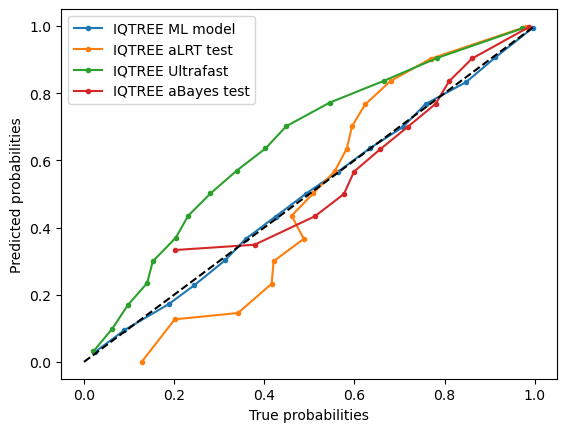

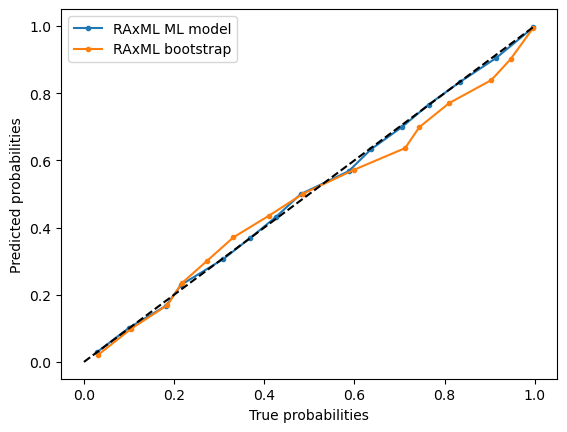

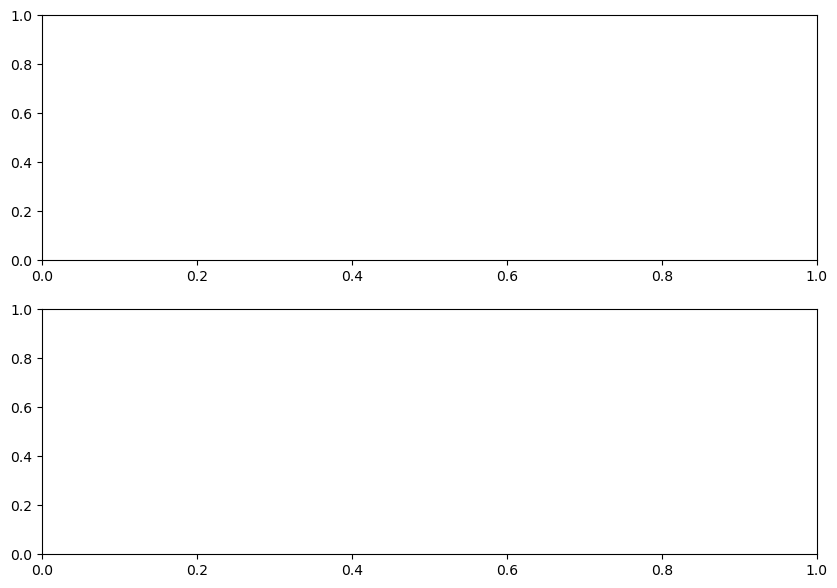

In [51]:
calibration_plot({'IQTREE ML model':iqtree_test_data['predictions_full_standard'],
    'IQTREE aLRT test':iqtree_test_data['predictions_feature_aLRT_iqtree_support_raw_boot'],
                  'IQTREE Ultrafast':iqtree_test_data['predictions_bootstrap_support_raw_boot'],
                 'IQTREE aBayes test':iqtree_test_data['predictions_feature_aBayes_iqtree_support_raw_boot'],
                 }, iqtree_test_data["true_binary_support"])


calibration_plot({
                  'RAxML ML model':raxml_test_data['predictions_full_standard'],
    'RAxML bootstrap':raxml_test_data['predictions_bootstrap_support_raw_boot'],
                 }, raxml_test_data["true_binary_support"])


figure, axes = plt.subplots(2, 1, figsize=(10, 7))


#calibration_plot({
#                  'Fasttree ML model':fasttree_test_data['predictions_full_standard'],
#    'Fasttree SH test':fasttree_test_data['predictions_bootstrap_support_raw_boot'],
#                 }, fasttree_test_data["true_binary_support"])






In [ ]:
import numpy as np
